**СОЗДАНИЕ ЧАТ-БОТА НА ОСНОВЕ ДАТАСЕТА ДИАЛОГОВ ИЗ КИНОФИЛЬМОВ**

Простой чат-бот будет создан с помощью нейронной сети. В работе применён датасет Cornell Movie-Dialogs Corpus. В нем собрано более 220 тысяч реплик из 617 кинофильмов. Датасет и его описание доступны по [ссылке](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html).

**Загрузка библиотек**

Загрузим необходимые библиотеки и проверим текущую версию tensorflow

In [1]:
pip install livelossplot

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from livelossplot.tf_keras import PlotLossesCallback
from pathlib import Path

print(tf.__version__)

2.5.0


Подключим Google Drive

In [3]:
if True:
    from google.colab import drive
    drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Загрузка данных**

Создадим два датафрейма.

df_lines:
* line_id - идентификатор реплики;
* character_id - идентификатор персонажа, который произносит реплику;
* move_id - идентификатор фильма, в котором происходит действие;
* name - имя персонажа, который произносит реплику;
* line - реплика.


df_conversations:
* character1_id - идентификатор первого персонажа в диалоге
* character2_id - идентификатор второго персонажа в диалоге
* move_id - идентификатор фильма, в котором происходит действие;
* line_order - порядок реплик в диалоге

In [4]:
df_lines = pd.read_csv('/content/drive/MyDrive/movie_lines.txt', sep='\ \+\+\+\$\+\+\+\ ', engine='python',
                      names=['line_id', 'character_id', 'movie_id', 'name', 'line'])
df_lines.head()

,line_id,character_id,movie_id,name,line
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.


In [5]:
df_conversations = pd.read_csv('/content/drive/MyDrive/movie_conversations.txt', sep='\ \+\+\+\$\+\+\+\ ', engine='python',
                              names=['character1_id', 'character2_id', 'movie_id', 'lines_order'])
df_conversations.head()

,character1_id,character2_id,movie_id,lines_order
0,u0,u2,m0,"['L194', 'L195', 'L196', 'L197']"
1,u0,u2,m0,"['L198', 'L199']"
2,u0,u2,m0,"['L200', 'L201', 'L202', 'L203']"
3,u0,u2,m0,"['L204', 'L205', 'L206']"
4,u0,u2,m0,"['L207', 'L208']"


Выведем основную информацию о датафреймах

In [6]:
df_conversations.describe()

,character1_id,character2_id,movie_id,lines_order
count,83097,83097,83097,83097
unique,5420,5608,617,83097
top,u4331,u1475,m289,"['L588377', 'L588378', 'L588379', 'L588380', '..."
freq,193,187,338,1


In [7]:
df_conversations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83097 entries, 0 to 83096
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   character1_id  83097 non-null  object
 1   character2_id  83097 non-null  object
 2   movie_id       83097 non-null  object
 3   lines_order    83097 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB


In [8]:
df_lines.describe()

,line_id,character_id,movie_id,name,line
count,304713,304713,304713,304670,304446
unique,304713,9035,617,5413,265807
top,L214786,u4525,m289,JACK,What?
freq,1,537,1530,3032,1684


In [9]:
df_lines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304713 entries, 0 to 304712
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   line_id       304713 non-null  object
 1   character_id  304713 non-null  object
 2   movie_id      304713 non-null  object
 3   name          304670 non-null  object
 4   line          304446 non-null  object
dtypes: object(5)
memory usage: 11.6+ MB


**Обработка данных**

В датафрейме df_lines в столбце с репликами ('lines') есть пропущенные значения. Не будем их удалять, чтобы не нарушать структуру диалогов, а заменим их на многозначительное молчание


In [45]:
df_lines['line'].fillna('Hmm', inplace = True)

Создадим словарь для декодирования реплик: из 'line_id' в 'line'

In [46]:
line_decoder = {line_id:line for line_id, line in zip(df_lines['line_id'].values, df_lines['line'].values)}

Создадим список всех диалогов. Отбросим все диалоги, которые  содержат реплики длинной более 50 символов, чтобы оптимизировать обучение и работу чат-бота

In [47]:
conversations = df_conversations['lines_order'].values 
conversations_list = [] 
Length_of_phrase = 35

for lines in conversations:
    lines = lines[2:-2].split('\', \'')
    phrase_list = []
    Flag = True
    for line in lines:
        phrase = line_decoder.get(line)
        if len(phrase) <= Length_of_phrase:
            phrase_list.append(phrase)     
        else:
            Flag = False
            break
    if Flag:
        conversations_list.append(phrase_list)  

Разделим все диалоги на пары реплик

In [48]:
first_lines = [line for conversation in conversations_list for line in conversation[:-1]]
second_lines = [line for conversation in conversations_list for line in conversation[1:]]

Протестируем результат разбиения

In [49]:
for i in range(10):
    print(f'Line:\n{first_lines[i]}\nReply:\n{second_lines[i]}\n-----------------------')

Line:
There.
Reply:
Where?
-----------------------
Line:
You have my word.  As a gentleman
Reply:
You're sweet.
-----------------------
Line:
Have fun tonight?
Reply:
Tons
-----------------------
Line:
Well, no...
Reply:
Then that's all you had to say.
-----------------------
Line:
Then that's all you had to say.
Reply:
But
-----------------------
Line:
But
Reply:
You always been this selfish?
-----------------------
Line:
Wow
Reply:
Let's go.
-----------------------
Line:
She okay?
Reply:
I hope so.
-----------------------
Line:
They do to!
Reply:
They do not!
-----------------------
Line:
Did you change your hair?
Reply:
No.
-----------------------


**Кодирование данных**

Подготовим функцию, для создания словарей и их кодирования

In [50]:
def prepare_vocab(texts):
    vocab = sorted(set(''.join(texts)))
    vocab.append('<START>')
    vocab.append('<END>')
    vocab_size = len(vocab)
    char2idx = {u:i for i, u in enumerate(vocab)}
    idx2char = np.array(vocab)
    return vocab_size, char2idx, idx2char

INPUT_VOCAB_SIZE, input_char2idx, input_idx2char = prepare_vocab(first_lines)
TARGET_VOCAB_SIZE, target_char2idx, target_idx2char = prepare_vocab(second_lines)

С помощью полученых словарей закодируем текстовые последовательности

In [51]:
input_texts_as_int = [[input_char2idx[c] for c in text] for text in first_lines]
target_texts_as_int = [[target_char2idx[c] for c in text] for text in second_lines]

encoder_input_seqs = [np.array(text) for text in input_texts_as_int]
decoder_input_seqs = []
decoder_target_seqs = []
for target_text in target_texts_as_int:
    decoder_input_seqs.append(np.array([target_char2idx['<START>']] + target_text))
    decoder_target_seqs.append(np.array(target_text + [target_char2idx['<END>']]))

Подготовим входные данные для нейросети с применением паддинга

In [52]:
max_enc_seq_length = max([len(seq) for seq in encoder_input_seqs])
max_dec_seq_length = max([len(seq) for seq in decoder_input_seqs])

encoder_input_seqs = tf.keras.preprocessing.sequence.pad_sequences(
    encoder_input_seqs,
    value=input_char2idx[' '],
    padding='post',
    maxlen=max_enc_seq_length)

decoder_input_seqs = tf.keras.preprocessing.sequence.pad_sequences(
    decoder_input_seqs,
    value=target_char2idx[' '],
    padding='post',
    maxlen=max_dec_seq_length)

decoder_target_seqs = tf.keras.preprocessing.sequence.pad_sequences(
    decoder_target_seqs,
    value=target_char2idx[' '],
    padding='post',
    maxlen=max_dec_seq_length)

**Создание и обучение модели**

Создадим модель с применением Attention

In [53]:
H_SIZE = 256     # размерность скрытого состояния LSTM
EMB_SIZE = 256   # размерность эмбеддингов

class Encoder_att(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.embed = tf.keras.layers.Embedding(INPUT_VOCAB_SIZE, EMB_SIZE)
        self.lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(H_SIZE, return_sequences=True, return_state=True))
        self.lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(H_SIZE, return_sequences=True, return_state=True))
        self.lstm_3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(H_SIZE, return_sequences=True, return_state=True))
        self.lstm_4 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(H_SIZE, return_sequences=True, return_state=True))
        self.lstm_5 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(H_SIZE, return_sequences=True, return_state=True))
        
    def call(self, x):
        out = self.embed(x)
        out, f_h_1, f_c_1, b_h_1, b_c_1 = self.lstm_1(out)
        out, f_h_2, f_c_2, b_h_2, b_c_2 = self.lstm_2(out)
        out, f_h_3, f_c_3, b_h_3, b_c_3 = self.lstm_3(out)
        out, f_h_4, f_c_4, b_h_4, b_c_4 = self.lstm_4(out)
        out, f_h_5, f_c_5, b_h_5, b_c_5 = self.lstm_5(out)
        h_1 = tf.keras.layers.Concatenate()([f_h_1, b_h_1])
        c_1 = tf.keras.layers.Concatenate()([f_c_1, b_c_1])
        h_2 = tf.keras.layers.Concatenate()([f_h_2, b_h_2])
        c_2 = tf.keras.layers.Concatenate()([f_c_2, b_c_2])
        h_3 = tf.keras.layers.Concatenate()([f_h_3, b_h_3])
        c_3 = tf.keras.layers.Concatenate()([f_c_3, b_c_3])
        h_4 = tf.keras.layers.Concatenate()([f_h_4, b_h_4])
        c_4 = tf.keras.layers.Concatenate()([f_c_4, b_c_4])
        h_5 = tf.keras.layers.Concatenate()([f_h_5, b_h_5])
        c_5 = tf.keras.layers.Concatenate()([f_c_5, b_c_5])
        state_1 = (h_1, c_1)
        state_2 = (h_2, c_2)
        state_3 = (h_3, c_3)
        state_4 = (h_4, c_4)
        state_5 = (h_5, c_5)
        return out, (state_1, state_2, state_3, state_4, state_5)

class Decoder_att(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.embed = tf.keras.layers.Embedding(TARGET_VOCAB_SIZE, EMB_SIZE)
        self.lstm_1 = tf.keras.layers.LSTM(H_SIZE*2, return_sequences=True, return_state=True)
        self.lstm_2 = tf.keras.layers.LSTM(H_SIZE*2, return_sequences=True, return_state=True)
        self.lstm_3 = tf.keras.layers.LSTM(H_SIZE*2, return_sequences=True, return_state=True)
        self.lstm_4 = tf.keras.layers.LSTM(H_SIZE*2, return_sequences=True, return_state=True)
        self.lstm_5 = tf.keras.layers.LSTM(H_SIZE*2, return_sequences=True, return_state=True)
        self.attention = tf.keras.layers.Attention()
        self.fc = tf.keras.layers.Dense(TARGET_VOCAB_SIZE, activation='softmax')
        
    def call(self, x, init_state, encoder_outputs, training=True):
        out = self.embed(x)
        out, h_1, c_1 = self.lstm_1(out, initial_state=init_state[0])
        out, h_2, c_2 = self.lstm_2(out, initial_state=init_state[1])
        out, h_3, c_3 = self.lstm_3(out, initial_state=init_state[2])
        out, h_4, c_4 = self.lstm_4(out, initial_state=init_state[3])
        out, h_5, c_5 = self.lstm_5(out, initial_state=init_state[4])
        out = self.attention([out, encoder_outputs], training=training)
        out = self.fc(out)
        state_1 = (h_1, c_1)
        state_2 = (h_2, c_2)
        state_3 = (h_3, c_3)
        state_4 = (h_4, c_4)
        state_5 = (h_5, c_5)
        return out, (state_1, state_2, state_3, state_4, state_5)

encoder_model_att = Encoder_att()
decoder_model_att = Decoder_att()

encoder_inputs_att = tf.keras.layers.Input(shape=(None,))
decoder_inputs_att = tf.keras.layers.Input(shape=(None,))

encoder_outputs_att, enc_state_att = encoder_model_att(encoder_inputs_att)
decoder_outputs_att, _ = decoder_model_att(decoder_inputs_att, enc_state_att, encoder_outputs_att)

seq2seq_att = tf.keras.Model([encoder_inputs_att, decoder_inputs_att], decoder_outputs_att)
seq2seq_att.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_att_2 (Encoder_att)     ((None, None, 512),  7373056     input_5[0][0]                    
__________________________________________________________________________________________________
decoder_att_2 (Decoder_att)     ((None, None, 90), ( 10040922    input_6[0][0]                    
                                                                 encoder_att_2[0][1]        

Настроим логирование и создание чекпоинтов модели

In [54]:
path = Path("/content/drive/MyDrive/chat_bot")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.hdf5"
cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    cpt_path, 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True, 
    mode='max'
)

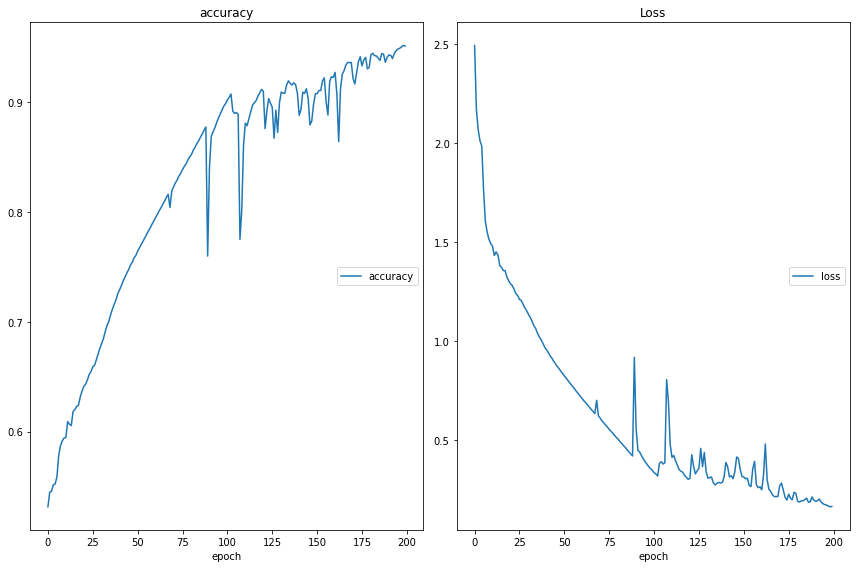

accuracy
	accuracy         	 (min:    0.531, max:    0.952, cur:    0.952)
Loss
	loss             	 (min:    0.163, max:    2.492, cur:    0.164)


In [55]:
BATCH_SIZE = 512
EPOCHS = 200

loss = tf.losses.SparseCategoricalCrossentropy()
seq2seq_att.compile(optimizer='rmsprop', loss=loss, metrics=['accuracy'])
history = seq2seq_att.fit([encoder_input_seqs, decoder_input_seqs], decoder_target_seqs,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=[PlotLossesCallback()])

Сделаем дополнительно сохранение модели в конце обучения

In [56]:
seq2seq_att.save_weights('/content/drive/MyDrive/model_att_saved')

**Инференс модели**

Создадим функцию для инференса модели

In [57]:
def seq2seq_att_inference(input_seq):

    output, state = encoder_model_att(input_seq)
    target_seq = np.array([[target_char2idx['<START>']]])
    decoded_sentence = ''
    
    while True:
        output_tokens, state = decoder_model_att(target_seq, state, output, training=False)
        sampled_token_index = np.argmax(np.array(output_tokens[0, -1, :]))
        sampled_char = target_idx2char[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '<END>' or
           len(decoded_sentence) > max_dec_seq_length):
            break

        target_seq = np.array([[sampled_token_index]])

    return decoded_sentence

Проверим работу чат-бота. Создадим функцию, которая добавит паддинг к входящим данным

In [58]:
def next_line(line):
    int_seq = np.array([input_char2idx[c] for c in line])
    int_seq_pad = np.zeros(max_enc_seq_length)
    int_seq_pad[:len(int_seq)] = int_seq
    int_seq_pad = int_seq_pad.reshape(1, -1)
    decoded = seq2seq_att_inference(int_seq_pad)
    if decoded[-5:] == '<END>':
        decoded = decoded[:-5]
    decoded = decoded.rstrip()
    return decoded

print(f"Line:\nHello!\nReply:\n{next_line('Hello!')}\n------------------")
print(f"Line:\nHi there!\nReply:\n{next_line('Hi there!')}\n------------------")
print(f"Line:\nWhat is your name?\nReply:\n{next_line('What is your name?')}\n------------------")
print(f"Line:\nHow do you do?\nReply:\n{next_line('How do you do?')}\n------------------")
print(f"Line:\nHow old are you?\nReply:\n{next_line('How old are you?')}\n------------------")
print(f"Line:\nWhat is your favourite move?\nReply:\n{next_line('What is your favourite move?')}\n------------------")
print(f"Line:\nTell me something new\nReply:\n{next_line('Tell me something new')}\n------------------")
print(f"Line:\nWhat is new?\nReply:\n{next_line('What is new?')}\n------------------")

Line:
Hello!
Reply:
A nieeanep-it'po.
------------------
Line:
Hi there!
Reply:
No.  We straiendDed hive a foon.
------------------
Line:
What is your name?
Reply:
I don't know. I guess it was...
------------------
Line:
How do you do?
Reply:
A pened-tWet a book gleam.?
------------------
Line:
How old are you?
Reply:
About twenty minutes.
------------------
Line:
What is your favourite move?
Reply:
It's cool, I'm just looking.
------------------
Line:
Tell me something new
Reply:
Yeah....
------------------
Line:
What is new?
Reply:
I don't know. I guess it was...
------------------
